# Negative L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 5922.86767578125
iteration 0 loss 1661.3154296875


iteration 5000 loss 10.140716552734375


iteration 10000 loss 1.2081775665283203


iteration 15000 loss 0.3304123878479004


iteration 20000 loss 0.13272862136363983


iteration 25000 loss 0.09527982026338577


iteration 30000 loss 0.07555964589118958


iteration 35000 loss 0.06487435102462769


iteration 40000 loss 0.056544750928878784


iteration 45000 loss 0.05014793202280998


iteration 50000 loss 0.04537469148635864


iteration 55000 loss 0.04209767282009125


iteration 60000 loss 0.03881440311670303


iteration 65000 loss 0.036322761327028275


iteration 70000 loss 0.034263212233781815


iteration 75000 loss 0.03235434368252754


iteration 80000 loss 0.030730336904525757


iteration 85000 loss 0.029280824586749077


iteration 90000 loss 0.02791590243577957


iteration 95000 loss 0.02667280286550522


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.025670068338513374


iteration 105000 loss 0.02530062198638916


iteration 110000 loss 0.024207133799791336


iteration 115000 loss 0.023295722901821136


iteration 120000 loss 0.0224174652248621


iteration 125000 loss 0.0215473473072052


iteration 130000 loss 0.020802712067961693


iteration 135000 loss 0.02011774480342865


iteration 140000 loss 0.019437354058027267


iteration 145000 loss 0.0188481155782938


iteration 150000 loss 0.0183559637516737


iteration 155000 loss 0.01780029386281967


iteration 160000 loss 0.01731206476688385


iteration 165000 loss 0.01689855381846428


iteration 170000 loss 0.01645682193338871


iteration 175000 loss 0.016004834324121475


iteration 180000 loss 0.015630943700671196


iteration 185000 loss 0.015228508971631527


iteration 190000 loss 0.014882585033774376


iteration 195000 loss 0.014551102183759212


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.014190450310707092


iteration 205000 loss 0.014126039110124111


iteration 210000 loss 0.013815836980938911


iteration 215000 loss 0.013474472798407078


iteration 220000 loss 0.013192277401685715


iteration 225000 loss 0.012893092818558216


iteration 230000 loss 0.012600989080965519


iteration 235000 loss 0.012334594503045082


iteration 240000 loss 0.012097800150513649


iteration 245000 loss 0.011859484016895294


iteration 250000 loss 0.011613896116614342


iteration 255000 loss 0.011381338350474834


iteration 260000 loss 0.011177663691341877


iteration 265000 loss 0.010977832600474358


iteration 270000 loss 0.010756682604551315


iteration 275000 loss 0.010551833547651768


iteration 280000 loss 0.010349412448704243


iteration 285000 loss 0.010194006375968456


iteration 290000 loss 0.01000866200774908


iteration 295000 loss 0.009826023131608963


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.009653626941144466


iteration 305000 loss 0.009626887738704681


iteration 310000 loss 0.009538878686726093


iteration 315000 loss 0.009443322196602821


iteration 320000 loss 0.009351318702101707


iteration 325000 loss 0.009262164123356342


iteration 330000 loss 0.009175417013466358


iteration 335000 loss 0.009091001935303211


iteration 340000 loss 0.009008803404867649


iteration 345000 loss 0.008928014896810055


iteration 350000 loss 0.008848614990711212


iteration 355000 loss 0.008770703338086605


iteration 360000 loss 0.008694215677678585


iteration 365000 loss 0.008619071915745735


iteration 370000 loss 0.0085452226921916


iteration 375000 loss 0.00847257673740387


iteration 380000 loss 0.008401184342801571


iteration 385000 loss 0.00833085272461176


iteration 390000 loss 0.008261602371931076


iteration 395000 loss 0.00819335225969553


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.008126120083034039


iteration 405000 loss 0.008119979873299599


iteration 410000 loss 0.008113491348922253


iteration 415000 loss 0.008107101544737816


iteration 420000 loss 0.0081007806584239


iteration 425000 loss 0.008094512857496738


iteration 430000 loss 0.008088281378149986


iteration 435000 loss 0.008082115091383457


iteration 440000 loss 0.008075964637100697


iteration 445000 loss 0.008069868199527264


iteration 450000 loss 0.008063802495598793


iteration 455000 loss 0.008057758212089539


iteration 460000 loss 0.008051729761064053


iteration 465000 loss 0.008045748807489872


iteration 470000 loss 0.00803979393094778


iteration 475000 loss 0.008033854886889458


iteration 480000 loss 0.008027933537960052


iteration 485000 loss 0.00802203081548214


iteration 490000 loss 0.008016176521778107


iteration 495000 loss 0.00801031943410635


L2 loss -- Plot

loss 377.2515563964844


loss 301.428466796875


loss 277.76611328125


loss 267.5865478515625


loss 262.8717041015625


loss 260.67578125


loss 259.7003479003906


loss 259.3065185546875


loss 259.16937255859375


loss 259.13055419921875


loss 259.12225341796875


loss 259.12103271484375


loss 259.12091064453125


loss 259.12091064453125


loss 259.1208801269531


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.1208801269531


loss 259.12091064453125


loss 259.1208801269531


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.1208801269531


loss 259.1208801269531


loss 259.12091064453125


loss 259.1208801269531


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.1208801269531


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


loss 259.12091064453125


final mse:  8.762083503199847e-09
max, min: 2.328057 -2.1803782
loss 377.2515563964844


loss 300.5821533203125


loss 275.9854736328125


loss 265.51507568359375


loss 260.7687072753906


loss 258.61614990234375


loss 257.684814453125


loss 257.3175048828125


loss 257.1920166015625


loss 257.1571044921875


loss 257.1497802734375


loss 257.14874267578125


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.1485900878906


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


loss 257.14862060546875


final mse:  7.247271227583951e-09
max, min: 2.3112757 -2.133262


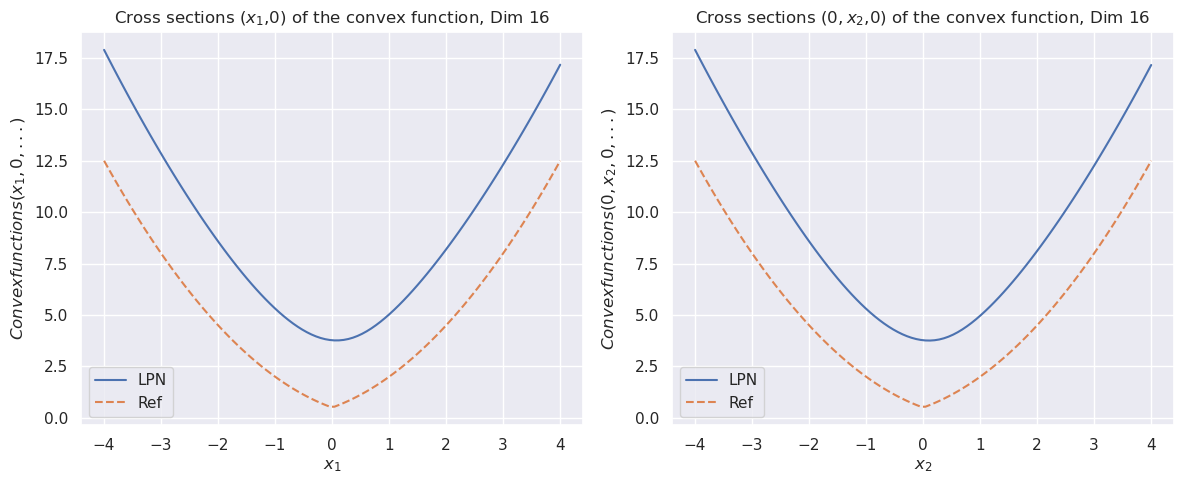

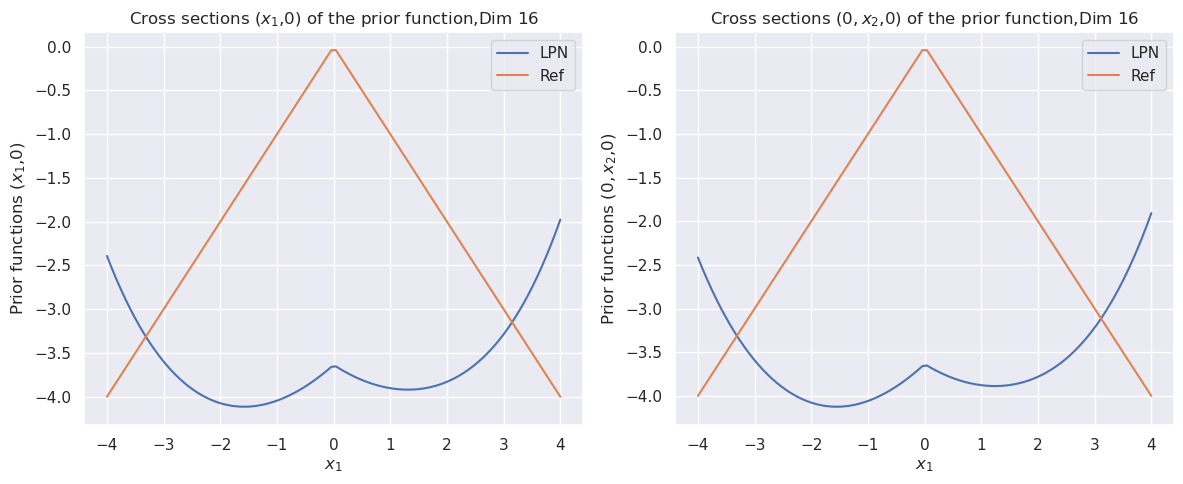

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1753.6778564453125
iteration 0 loss 211.96974182128906


iteration 5000 loss 5.227752685546875


iteration 10000 loss 0.7867938876152039


iteration 15000 loss 0.5715739727020264


iteration 20000 loss 0.48401010036468506


iteration 25000 loss 0.4223247468471527


iteration 30000 loss 0.36282870173454285


iteration 35000 loss 0.31948453187942505


iteration 40000 loss 0.2898939549922943


iteration 45000 loss 0.2674974799156189


iteration 50000 loss 0.2486356496810913


iteration 55000 loss 0.23265498876571655


iteration 60000 loss 0.22155557572841644


iteration 65000 loss 0.21267932653427124


iteration 70000 loss 0.20274704694747925


iteration 75000 loss 0.19502659142017365


iteration 80000 loss 0.19000476598739624


iteration 85000 loss 0.1835920363664627


iteration 90000 loss 0.17842906713485718


iteration 95000 loss 0.17382515966892242


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.16940662264823914


iteration 105000 loss 0.1679961234331131


iteration 110000 loss 0.16327714920043945


iteration 115000 loss 0.1586957573890686


iteration 120000 loss 0.1543155461549759


iteration 125000 loss 0.15002837777137756


iteration 130000 loss 0.14618702232837677


iteration 135000 loss 0.14280520379543304


iteration 140000 loss 0.13906823098659515


iteration 145000 loss 0.13571679592132568


iteration 150000 loss 0.13240918517112732


iteration 155000 loss 0.12907634675502777


iteration 160000 loss 0.1263241022825241


iteration 165000 loss 0.12360122799873352


iteration 170000 loss 0.12087518721818924


iteration 175000 loss 0.11769341677427292


iteration 180000 loss 0.11419062316417694


iteration 185000 loss 0.11049675941467285


iteration 190000 loss 0.10671935230493546


iteration 195000 loss 0.10347778350114822


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.10042116791009903


iteration 205000 loss 0.09958254545927048


iteration 210000 loss 0.09705100208520889


iteration 215000 loss 0.09450649470090866


iteration 220000 loss 0.09203263372182846


iteration 225000 loss 0.0895322933793068


iteration 230000 loss 0.08696797490119934


iteration 235000 loss 0.08438331633806229


iteration 240000 loss 0.08183527737855911


iteration 245000 loss 0.07936245203018188


iteration 250000 loss 0.07691523432731628


iteration 255000 loss 0.0744093731045723


iteration 260000 loss 0.07192150503396988


iteration 265000 loss 0.06943754851818085


iteration 270000 loss 0.06694414466619492


iteration 275000 loss 0.06441137939691544


iteration 280000 loss 0.0617942251265049


iteration 285000 loss 0.05909769609570503


iteration 290000 loss 0.056407805532217026


iteration 295000 loss 0.053810808807611465


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.05130429565906525


iteration 305000 loss 0.05101317539811134


iteration 310000 loss 0.050709422677755356


iteration 315000 loss 0.05041069537401199


iteration 320000 loss 0.05011502280831337


iteration 325000 loss 0.04982173815369606


iteration 330000 loss 0.049529965966939926


iteration 335000 loss 0.049239274114370346


iteration 340000 loss 0.04894943907856941


iteration 345000 loss 0.048660263419151306


iteration 350000 loss 0.048371344804763794


iteration 355000 loss 0.04808276519179344


iteration 360000 loss 0.047794412821531296


iteration 365000 loss 0.047505781054496765


iteration 370000 loss 0.04721689969301224


iteration 375000 loss 0.046927426010370255


iteration 380000 loss 0.0466374047100544


iteration 385000 loss 0.046346988528966904


iteration 390000 loss 0.046055860817432404


iteration 395000 loss 0.045763883739709854


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.04547121003270149


iteration 405000 loss 0.04544476792216301


iteration 410000 loss 0.045418377965688705


iteration 415000 loss 0.045392073690891266


iteration 420000 loss 0.04536578804254532


iteration 425000 loss 0.04533959925174713


iteration 430000 loss 0.04531342163681984


iteration 435000 loss 0.045287277549505234


iteration 440000 loss 0.045261163264513016


iteration 445000 loss 0.045235078781843185


iteration 450000 loss 0.04520900174975395


iteration 455000 loss 0.0451829619705677


iteration 460000 loss 0.04515695199370384


iteration 465000 loss 0.04513094946742058


iteration 470000 loss 0.0451049730181694


iteration 475000 loss 0.04507900029420853


iteration 480000 loss 0.04505307599902153


iteration 485000 loss 0.045027170330286026


iteration 490000 loss 0.04500136896967888


iteration 495000 loss 0.04497556760907173


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


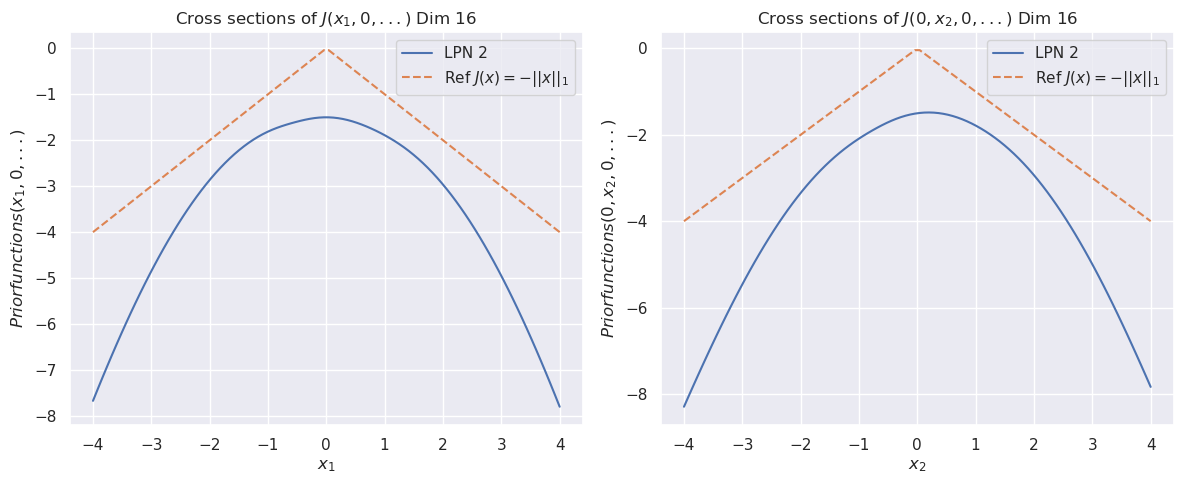

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)